In [1]:
using ComputationalHeatTransfer

In [2]:
# using Plots
using LaTeXStrings

In [3]:
using Revise
using LinearAlgebra
using DifferentialEquations
using Interpolations
# using JLD
using Plots
pyplot()  

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise C:\Users\liyux\.julia\packages\Revise\1boD5\src\packagedef.jl:1369


Plots.PyPlotBackend()

In [4]:
using JLD2

In [5]:
cd(dirname(pwd()))
cd("src") 

includet("OneDOHP.jl")
using ..OneDOHP

# the plate code initialization

### Physical parameters

In [6]:
ρ = 2702;
c = 9.03e02;
k = 2.37e02;
d = 2e-3;
params = HeatConductionParameters(ρ,c,k,thickness=d)

HeatConductionParameters(2702.0, 903.0, 237.0, 9.713488962279695e-5, 0.002)

### Geometry parameters

In [7]:
Lx = 0.1524
Ly = 0.0648;
inch = 2.54e-2;

In [8]:
xlim = (-Lx/2,Lx/2) .* 1.1
ylim = (-Ly/2,Ly/2) .* 1.1
# Δx, Δt = setstepsizes(params.α,gridPe=0.1,fourier=200.0)
Δx, Δt = setstepsizes(params.α,gridPe=8.0,fourier=0.15)
# Δx, Δt = setstepsizes(params.α,gridPe=5.0,fourier=1000000.0)

Δt = 1e-3

0.001

### Set up the boundary of the domain

In [9]:
bdry = Rectangle(Lx/2,Ly/2,1.5Δx)

Rectangular body with 368 points and half-lengths (0.0762,0.0324)
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


### Set up the evaporator and condenser

In [10]:
eb = Rectangle(inch,inch,1.5*Δx)
Te = RigidTransform((0.0,-0.0),0.0)
Te(eb)
cb1 = Rectangle(0.5inch,inch,1.5*Δx)
Tc = RigidTransform((-2inch,-0.0),0.0)
Tc(cb1)

cb2 = Rectangle(0.5inch,inch,1.5*Δx)
Tc = RigidTransform((2inch,-0.0),0.0)
Tc(cb2)

qe = 15500.0
hc = 2000.0
Tc = 0.0

eparams = PrescribedHeatFluxRegion(qe,eb);
cparams1 = PrescribedHeatModelRegion(hc,Tc,cb1);
cparams2 = PrescribedHeatModelRegion(hc,Tc,cb2);

### Set up the OHP

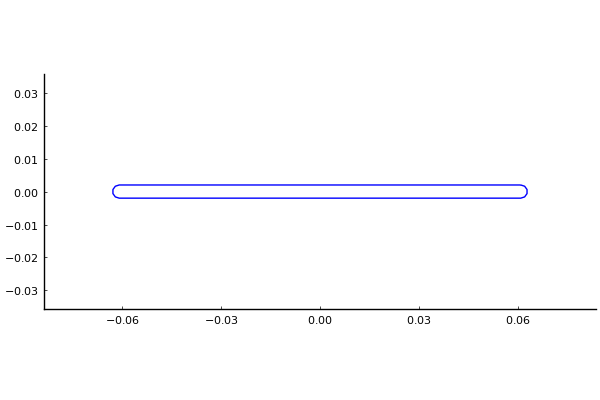

In [13]:
ds = 1.5Δx
nturn = 0.2
#pitch = 0.125
length_ohp = Lx*0.8
height = Ly*0.8
gap = 2*d
pitch = 0.1*length_ohp/(2*nturn+1)
x0, y0 = 0.0, 0.0
# x, y, xf, yf = ComputationalHeatTransfer.construct_ohp_curve(nturn,pitch,height,gap,ds,x0,y0,false,false,3pi/2)
x,y = construct_oneloop_curve(x0,y0,ds,length_ohp,gap,0.0)
ohp = BasicBody(x,y)

plot(ohp,fillalpha=0,linecolor=:blue,xlims=xlim,ylims=ylim)


In [14]:
ohpgeom = ComputationalHeatTransfer.LineSourceParams(ohp)
qtmp = zeros(numpts(ohp));

### Create the system

In [15]:
sys = HeatConduction(params,Δx,xlim,ylim,Δt,bodies=BodyList([bdry]),qline=ohpgeom,qflux=eparams,bctype=ComputationalHeatTransfer.AdiabaticBC,qmodel=[cparams1,cparams2])
#sys = HeatConduction(params,Δx,xlim,ylim,Δt,qline=ohpgeom)

Internal problem Heat conduction system on a grid of size 220 x 96 and 368 static immersed points
   1 body


#### Initialize state, and create the integrator

In [16]:
u0 = newstate(sys)
# tspan = (0.0,1.0)
tspan = (0.0,0.1)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Primal nodes in a (nx = 220, ny = 96) cell grid of type Float64 data
  Number of Primal nodes: (nx = 219, ny = 95), Float64[])

### Set up values for the OHP heat flux per unit length and advance the solution

In [17]:
fill!(qtmp,-0.0)
set_linesource_strength!(sys,qtmp)

Internal problem Heat conduction system on a grid of size 220 x 96 and 368 static immersed points
   1 body


In [18]:
# @time step!(integrator,1.0)
# maximum(integrator.u[:])

### Set the relative temperature back to [K]

In [19]:
T0 = 295.0 #[K]
# integrator.u += T0 - integrator.u[1,1]

295.0

### Plotting temperature contours

In [20]:
# plot(temperature(integrator),sys.grid,legend=true,color=cgrad(:RdBu,rev=true),clims=(T0-3.0,T0+3.0),line_z=0,xlabel="x [m]",ylabel="y [m]",title=L"T \quad [\mathrm{K}]")

### Plot the temperature along the OHP channel

In [21]:
# plot(ohp,fillalpha=0,line_z=temperature_linesource(integrator))

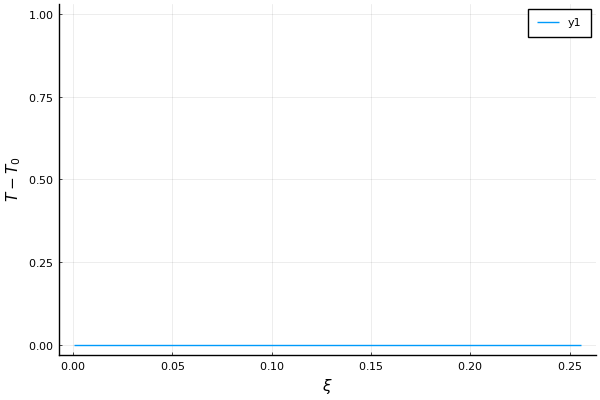

In [22]:
plot(sys.qline[1].arccoord,temperature_linesource(integrator),xlabel=L"\xi",ylabel=L"T - T_0")

# OHP inner part

In [23]:
nondi_Q_to_Q = 1.35E+02
t_to_nondi_t = 2.83E-01
function di_T_to_nondi_T(di_T;T0=295.0) 
    
    (di_T+T0)/T0
    
end



di_T_to_nondi_T (generic function with 1 method)

In [24]:
    ω = sqrt(2.45E+03);
    ℘L = 2.05E+05;
    k = 0.106024683

    θinitial=1.0
    θc = 1.0; # useless

    Hwc = 0.0; #not useful later on. H between wall and condenser, 
#     Hₗ   =  1600.0; # liquid wall heat transfer coeffcient
    Hₗ   =  2.32E+02; # liquid wall heat transfer coeffcient for static fluids
    Hδ  = 4.64E+02;


In [25]:
    d = 6.56e-3 # dimensionless diameter
    L = 2.0+gap/length_ohp*pi  # total length of the pipe when streched to a 1D pipe
    L2D = 1.0 # the actual length of the bended pipe in the real world
    angle = 0*pi/2 # inclination angle 
    closedornot = true

true

In [26]:
#     nucleatenum = 1
#     Xstations = sort(rand(nucleatenum).*L);
# #     boilingΔt = 0.05

Xstations = [0.5*L2D]

1-element Array{Float64,1}:
 0.5

In [27]:
tube = Tube(d,L,L2D,angle,closedornot);

In [28]:
# useless
Xe = map(tuple, [1.0], [3.0])
We = [0.0]
evap = Evaporator(Xe,We);

In [29]:
# useless
Xc = map(tuple, [0.0,3.0], [1.0,4.0])
cond = Condenser(θc,Xc,Hwc);

In [30]:
# numofX=2
# Xps = sort(rand(2*numofX).*L);
# Xp1s = Xps[1:2:end];
# Xp2s = Xps[2:2:end];

# dXdt0 = map(tuple,0*Xp1s,0*Xp2s)
# X0 = map(tuple,Xp1s,Xp2s);


In [31]:
N=numpts(ohp)
X0 = [(L2D*1/16, L2D*15/16)]
dXdt0 = [(0.0,0.0)]
ρ = 102.593344 # density ratio
Xarrays,θarrays = constructXarrays(X0,N,θinitial,L)
liquids=Liquid(Hₗ,ρ,ω,℘L,X0,dXdt0,Xarrays,θarrays);

In [32]:
# P = [1.0,1.0,1.0,1.0,1.0]; # closed end

γ = 1.4;
Hδ = 4.64E+02
P = 0*zeros(length(X0)) .+ 1.0;
δ = 0*zeros(length(X0)) .+ 2.78E-02;
vapors=Vapor(γ,Hδ,P,δ);

In [33]:
α = 0 # nondimensional thermal diffusivity = (αₐ d^2) / (νₗ height^2)
Xwallarray,θwallarray = constructXarrays(L,N,θinitial)
θwallarray = di_T_to_nondi_T(temperature_linesource(integrator));

wall = Wall(α,Δt,Xstations,Xwallarray,θwallarray);

In [34]:
sys0_nomapping = PHPSystem_nomapping(tube,evap,cond,liquids,vapors,wall);
θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall = sys_interpolation(sys0_nomapping)
mapping = Mapping(θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall);

In [35]:
sys0 = PHPSystem(tube,evap,cond,liquids,vapors,wall,mapping);

### construct state vector U

In [36]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L,sys0.tube.closedornot)
M = nondi_PtoD(P) .* Lvaporplug
# M = P.^(1/γ).* Lvaporplug


u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];

In [37]:
cb_boiling =  DiscreteCallback(boiling_condition,boiling_affect!)
# cb_boiling =  PeriodicCallback(boiling_affect!,0.01*t_to_nondi_t)
cb_merging =  DiscreteCallback(merging_condition,merging_affect!)

cbst = CallbackSet(cb_boiling,cb_merging);

# combine inner tube and plate together

In [57]:
tspan = (0.0, 4.0);
dt_record = tspan[2] /20;
tstep=1e-3;

In [58]:
u0 = newstate(sys)
integrator_plate = init(u0,tspan,sys)

t: 0.0
u: (Primal nodes in a (nx = 220, ny = 96) cell grid of type Float64 data
  Number of Primal nodes: (nx = 219, ny = 95), Float64[])

In [59]:
p = sys0
u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];
prob = ODEProblem(ODE_innertube, u, tspan, p)
integrator_tube = init(prob, RK4(),save_everystep=false, callback=cbst)

t: 0.0
u: 99-element Array{Float64,1}:
  0.0625
  0.9375
  0.0
  0.0
  1.2280705053844778
  0.0278
 -1.0e10
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  ⋮
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0

In [60]:
plate_hist = []
tube_hist  = []
currentsys = getcurrentsys(integrator_tube.u,sys0);

In [61]:

@time for t in tspan[1]:tstep:tspan[2]
    


    currentsys.wall.θarray = di_T_to_nondi_T(temperature_linesource(integrator_plate))
    currentsys = getcurrentsys(integrator_tube.u,currentsys)
    
    
    nondi_qtmp = sys_to_heatflux(currentsys)
    qtmp = nondi_Q_to_Q*nondi_qtmp
    set_linesource_strength!(sys,qtmp)
    
    
    # reinitialize the integrator_plate to avoid some mysterious problems
    integrator_plate = init(deepcopy(integrator_plate.u),(integrator_plate.t,integrator_plate.t + tstep),sys)
    step!(integrator_plate,tstep, true)
    
    
    # reinitialize the integrator_tube to avoid some mysterious problems
    prob = ODEProblem(ODE_innertube, deepcopy(integrator_tube.u), (integrator_plate.t*t_to_nondi_t-tstep*t_to_nondi_t,integrator_plate.t*t_to_nondi_t), currentsys)
    integrator_tube = init(prob, SSPRK22(), callback=cbst, dt=1e-4);
    solve!(integrator_tube);
#     @time step!(integrator_tube, tstep*t_to_nondi_t)

    if (mod(integrator_plate.t,dt_record) < 1e-6) || (mod(-integrator_plate.t,dt_record) < 1e-6)
        push!(plate_hist,deepcopy(integrator_plate)); 
        push!(tube_hist,deepcopy(integrator_tube));
        println(integrator_plate.t)
    end
    
end

0.20000000000000015
0.4000000000000003
Boiled!0.14150000000000007
0.6000000000000004
0.8000000000000006
1.0000000000000007
1.1999999999999786
1.3999999999999566
1.5999999999999346
1.7999999999999126
1.9999999999998905
2.1999999999998687
2.3999999999998467
2.5999999999998247
2.7999999999998026
2.9999999999997806
3.1999999999997586
3.3999999999997366
3.5999999999997145
3.7999999999996925
3.9999999999996705
425.576292 seconds (46.42 M allocations: 155.292 GiB, 3.97% gc time)


In [62]:
        push!(plate_hist,deepcopy(integrator_plate)); 
        push!(tube_hist,deepcopy(integrator_tube));
        println(integrator_plate.t)

4.000999999999671


In [63]:
sysfinal = []
for i = 1:length(tube_hist)
    plate_hist[i].u += T0 - plate_hist[i].u[1,1]
    push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
end

In [64]:
# plot(ohp,fillalpha=0,line_z=temperature_linesource(integrator_plate))

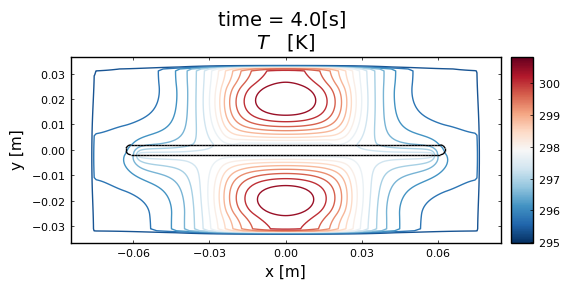

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
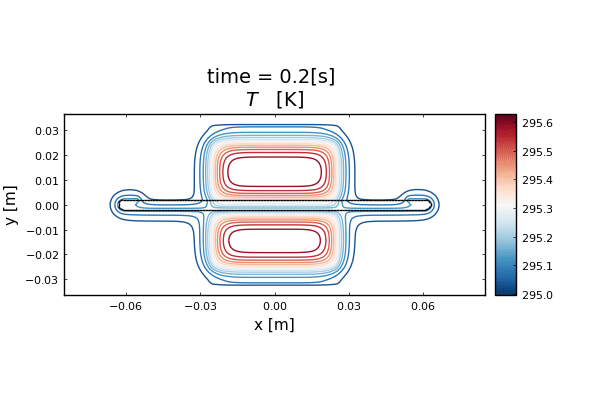

In [65]:
@gif for i = 1:1:length(plate_hist)
# @gif     for i = 1:1:1
Tmin = minimum(temperature(plate_hist[i])[:])
Tmax = maximum(temperature(plate_hist[i])[:])   
    
plot(temperature(plate_hist[i]),sys.grid,legend=true,color=cgrad(:RdBu,rev=true),clim=(Tmin,Tmax),line_z=0,xlabel="x [m]",ylabel="y [m]",title=string("time = ", round(plate_hist[i].t, digits=2), "[s] \n",  L"T \quad [\mathrm{K}]"))
plot!(ohp,fillalpha=0,line_z=0 .* qtmp)
end

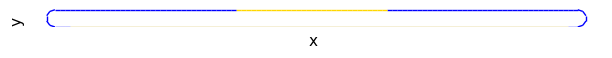

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
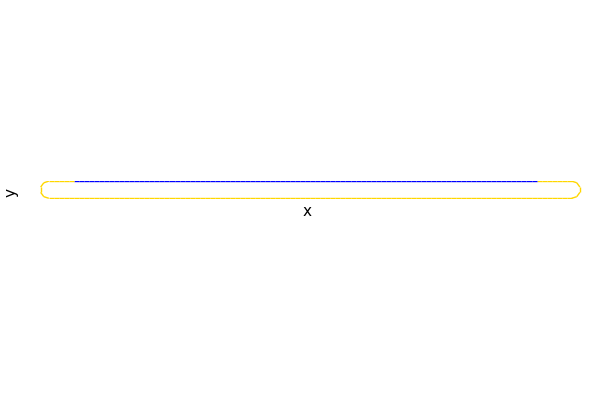

In [66]:
@gif for i=1:length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    plot(ohp,fillalpha=0,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,xlabel="x ",ylabel="y ",border=:none,axis=nothing)
end

# plot the OHP

In [67]:
sysfinal[end].liquid.Xp

2-element Array{Tuple{Float64,Float64},1}:
 (2.018595164040022, 0.3530245389222465)
 (0.6469754610777562, 1.0844754610777536)

In [68]:
sysfinal[end].mapping.P_interp_liquidtowall(0.4)

1.083528695426487

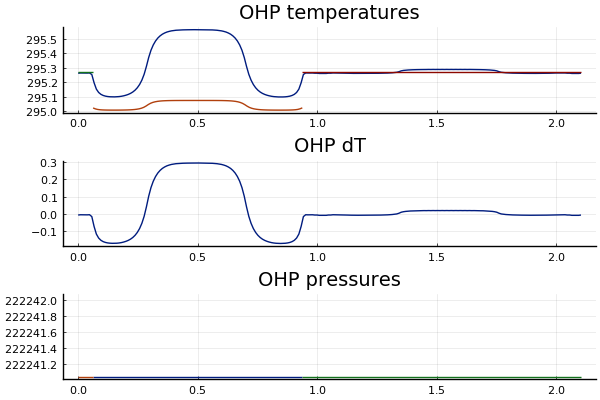

In [81]:
plot(sysfinal[2])

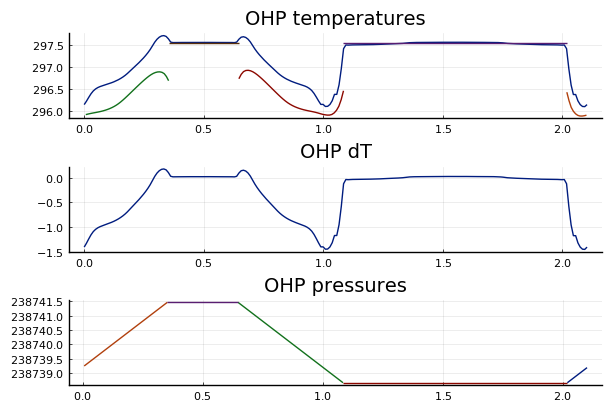

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
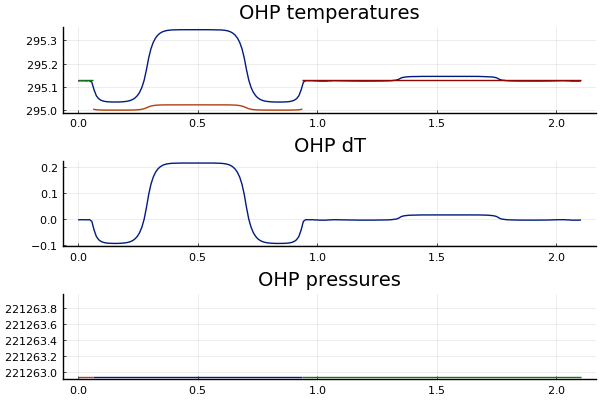

In [77]:
@gif for ii=1:length(sysfinal)
    plot(sysfinal[ii])
end

# temperature difference with OHP

### use the same definition of heat conductance in the ASET paper (temperature based on certain locations)

In [71]:
temp_evaporator = temperature(plate_hist[end])[110,48]

temp_condenser_1 = temperature(plate_hist[end])[44,48]
temp_condenser_2 = temperature(plate_hist[end])[end-44+1,48]
temp_condenser  = (temp_condenser_1+temp_condenser_2)/2

tempdiff_ASET = (temp_evaporator - temp_condenser) # K

0.4517893507772328

### use the same definition of heat conductance based on maximum and minimum temperatures)

In [72]:
tempdiff_maximum = maximum(temperature(plate_hist[end]))-minimum(temperature(plate_hist[end])) # K

5.8290775964603085

# thermal conductance with OHP

### use the same definition of heat conductance in the ASET paper (temperature based on certain locations)

In [73]:
heater_power = 40 #watt
cond_ASET =  heater_power /tempdiff_ASET # W/K

88.5368367607299

### use the same definition of heat conductance based on maximum and minimum temperatures)

In [74]:
heater_power = 40 #watt
cond_maximum =  heater_power /tempdiff_maximum # W/K

6.862149171644222

In [75]:
3+
3

6